### Implementing NBC classifier from scratch

In [1]:
import csv
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp
import warnings
import random
import math
       
def calc_prior_prob(X, c):
    cdataset = X[X['target'] == c]
    return cdataset.shape[0]/X.shape[0]

In [2]:
dataset = pd.read_csv('heart.csv')

In [3]:
print(calc_prior_prob(dataset, 0))
print(calc_prior_prob(dataset, 1))

0.4868292682926829
0.5131707317073171


In [4]:
dataset.iloc[5]
dataset.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [5]:
def posterior(X, x, c):
    cdataset = X[X['target'] == c]
    ans = 1.0
    columns = X.columns
    columns = np.delete(columns, -1)
    for col in columns:
        ans = ans * ((cdataset[cdataset[col] == x[col]]).shape[0]/cdataset.shape[0])
    return ans

In [6]:
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [7]:
# (70, 0, 0, 125, 203, 1, 0, 106, 0, 3.1, 0, 3, 3)
print(posterior(dataset, dataset.iloc[3], 1))

1.5713517818338483e-12


In [8]:
def classify(X, x):
    p0 = calc_prior_prob(X, 0) * posterior(X, x, 0)
    p1 = calc_prior_prob(X, 1) * posterior(X, x, 1)
    if p0>p1: return 0
    return 1

In [9]:
classify(dataset, dataset.iloc[3])

0

In [10]:
dataset.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1
1024,54,1,0,120,188,0,1,113,0,1.4,1,1,3,0


In [11]:
classify(dataset, dataset.iloc[1020])

1

In [12]:
training_data = dataset.sample(frac=0.8, random_state=25)
testing_data = dataset.drop(training_data.index)

In [13]:
print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 820
No. of testing examples: 205


In [14]:
def accuracy(train, test):
    count = 0
    numrows = test.shape[0]
    for i in range(numrows):
        if classify(train, test.iloc[i]) == test.iloc[i]['target']: count += 1
    return (count/numrows)*100.0

In [15]:
def predict(X):
    pred = []
    for i in range(X.shape[0]):
        pred.append(classify(X, X.iloc[i]))
    return np.array(pred)

In [16]:
print(accuracy(training_data, testing_data))

93.17073170731707


In [17]:
preds = predict(testing_data)

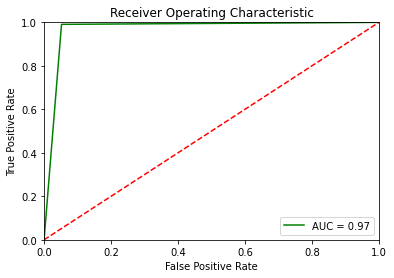

In [18]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(testing_data['target'], preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Implementing NBC with encryption

In [19]:
import tenseal as ts
from time import time

In [20]:
# parameters
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]
# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20
# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()

In [21]:
def encrypt_ds(X):
    numr = X.shape[0]
    for i in range(numr):
        for col in X.columns:
            X.at[i, col] = ts.ckks_vector(ctx_eval, [X.iloc[i][col]])

In [22]:
encrypt_ds(dataset)

In [23]:
dataset.iloc[3]['sex']

In [24]:
training_data = dataset.sample(frac=0.8, random_state=25)
testing_data = dataset.drop(training_data.index)

In [25]:
def decser(ser, c):
    if c == 1: return [k.decrypt()[0] > 0.95 for k in ser]
    return [k.decrypt()[0] < 0.95 for k in ser]
def calc_prior_prob_enc(X, c):
    cdataset = X.loc[decser(X['target'], c)]
    return cdataset.shape[0]

In [26]:
print(dataset.iloc[1023]['target'].decrypt())

[0.9995604277053977]


In [27]:
print(dataset.iloc[1022]['target'].decrypt())

[-0.0005134533003297061]


In [28]:
print(dataset.iloc[1021]['target'].decrypt())

[1.4754488428746736e-06]


In [29]:
print(dataset.iloc[1024]['target'].decrypt())

[-0.00028952055831912436]


In [30]:
print(dataset.iloc[1020]['target'].decrypt())

[0.9999537599277545]


In [31]:
print(calc_prior_prob_enc(training_data, 0))

403


In [32]:
print(calc_prior_prob_enc(training_data, 1))

417


In [33]:
def filt(ser, c):
    return [k.decrypt()[0] == c for k in ser]

In [38]:
def posterior_enc(X, x, c):
    cdataset = X.loc[decser(X['target'], c)]
    ans = 1.0
    columns = X.columns
    columns = np.delete(columns, -1)
    for col in columns:
        ans = ans * (cdataset[cdataset[col] == x[col]]).shape[0]*(1/cdataset.shape[0])
    return ts.ckks_vector(ctx_eval, [ans])

In [39]:
print(posterior_enc(dataset, dataset.iloc[4], 0))

In [44]:
def classify_enc(X, x):
    p0 = calc_prior_prob_enc(X, 0) * posterior_enc(X, x, 0)
    p1 = calc_prior_prob_enc(X, 1) * posterior_enc(X, x, 1)
    if p0.decrypt()>p1.decrypt(): return 0
    return 1

In [45]:
classify_enc(dataset, dataset.iloc[1020])

1

In [48]:
def predict_enc(X):
    pred = []
    for i in range(X.shape[0]):
        pred.append(classify_enc(X, X.iloc[i]))
    return np.array(pred)

In [49]:
predencr = predict_enc(dataset)

KeyboardInterrupt: 

In [ ]:
def accuracy(train, test):
    count = 0
    numrows = test.shape[0]
    for i in range(numrows):
        if classify_enc(train, test.iloc[i]) == test.iloc[i]['target']: count += 1
    return (count/numrows)*100.0